In [1]:
from memflow.phasespace import phasespace
import pdfflow
pdf = pdfflow.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
pdf.trace()
from memflow.hardscatter import hardscatter
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

/home/valsdav/code/MEM/MEMFlow/myenv/lib64/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-21 23:06:29.227232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 23:06:30.023047: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_3_2/lib:/.singularity.d/libs
2022-12-21 23:06:30.023196: W tensorflow/compiler/xla/stream_execut

In [33]:
TOP_MASS = 172.76
HIGGS_MASS = 125.25
E_CM = 13000
final_masses = torch.tensor([HIGGS_MASS, TOP_MASS, TOP_MASS], requires_grad=False)
N = 100000

In [57]:
p, w , x1, x2 = phasespace.generate_random_phase_space_points(N, E_CM, [21,21], final_masses, pdf)

/home/valsdav/code/MEM/MEMFlow/memflow/phasespace/rambo_generator.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.masses_t = torch.tensor(


In [58]:
inputs = np.transpose(p.numpy(), (0,2,1))

In [36]:
inputs.shape

(100000, 4, 5)

In [59]:
output = torch.zeros((N))
for i in range(inputs.shape[0]):
    output[i] = hardscatter.smatrix_ttH([21,21,25,6,-6], inputs[i])

In [46]:
%%timeit
output = torch.zeros((N))
for i in range(inputs.shape[0]):
    output[i] = hardscatter.smatrix_ttH([21,21,25,6,-6], inputs[i])

2.75 s ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit -n 10000
hardscatter.smatrix_ttH([21,21,25,6,-6], inputs[i] )

23.1 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [44]:
2.72 / 100000

2.72e-05

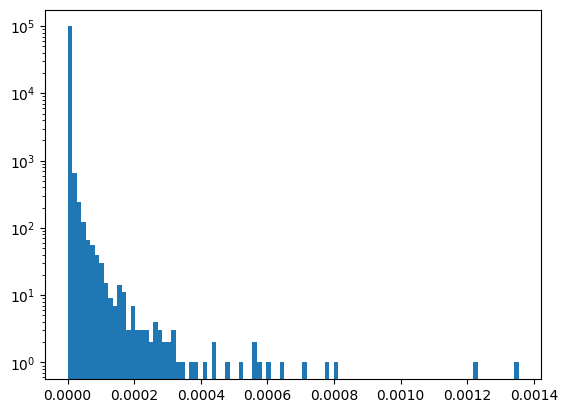

In [60]:
plt.hist(output, bins=100)
plt.yscale("log")

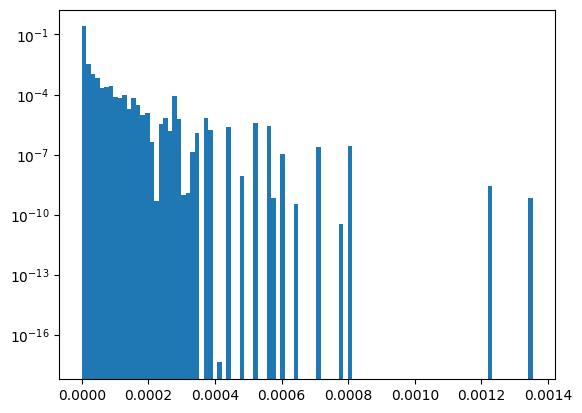

In [61]:
plt.hist(output, weights=w, bins=100)
plt.yscale("log")

In [42]:
phasespace.rambo_generator.FlatInvertiblePhasespace.get_flatWeights(E_CM, 3)

21291.052028166854

In [43]:
torch.sum(output*w)*phasespace.rambo_generator.FlatInvertiblePhasespace.get_flatWeights(E_CM, 3)

tensor(0.0106, dtype=torch.float64)

In [ ]:
plt.

In [67]:
w[w<0]

tensor([-3.3283e-19, -1.6937e-18, -2.2563e-20, -1.9972e-25, -4.8239e-21,
        -9.0008e-22, -6.5724e-19, -1.1879e-21, -1.6877e-17, -1.4989e-22,
        -5.5248e-19, -1.7926e-18, -3.8671e-18, -1.7287e-17, -7.8906e-17,
        -9.6893e-17, -3.6957e-18, -4.8051e-30, -4.9705e-20, -1.0356e-15,
        -1.8349e-19, -8.8347e-19, -1.4151e-20, -1.0559e-18, -7.1084e-18,
        -1.2098e-18, -3.2262e-20, -1.2523e-29, -7.7461e-16, -7.5434e-23,
        -1.2053e-17, -5.8860e-18, -6.1530e-18, -4.8244e-17, -2.9302e-27,
        -2.1675e-21, -2.0901e-16, -4.8510e-22, -1.9991e-25, -2.0283e-22,
        -8.6907e-27, -2.8000e-18, -6.5125e-18, -3.5343e-21, -1.9087e-19,
        -5.0948e-22, -9.3148e-24, -4.5058e-20, -2.2683e-17, -9.9292e-19,
        -3.3861e-22, -8.0207e-18, -2.1664e-17, -1.3370e-21, -3.7972e-23,
        -3.6755e-16, -1.8784e-17, -1.1258e-16, -1.6972e-18, -7.1202e-16,
        -1.9441e-17, -5.2090e-21, -1.2252e-19, -1.2142e-18, -1.9258e-22,
        -3.8891e-19, -1.4923e-18, -7.8733e-20, -7.0

In [66]:
torch.sum(w<0)

tensor(434)

In [80]:
torch.sum(output*w) / N

tensor(5.2239e-12, dtype=torch.float64)

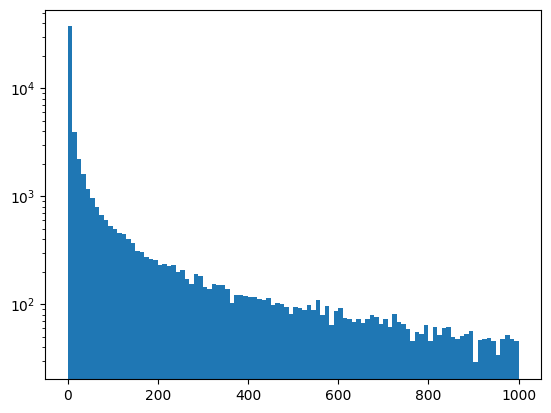

In [72]:
plt.hist(output/w, bins=100, range=(0,1000))
plt.yscale("log")

In [81]:
V = phasespace.rambo_generator.FlatInvertiblePhasespace.get_flatWeights(E_CM, 3)

In [85]:
(V / N ) * torch.sum(output)

tensor(0.0253)

In [89]:
torch.sum(output[w>1e-15]/w[w>1e-15]) / (N*V)

tensor(394.2604, dtype=torch.float64)